data taken from https://www.cs.toronto.edu/~kriz/cifar.html

In [1]:
import torch
from torch import nn
from torcheval.metrics import MulticlassAccuracy
import numpy as np
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
device = torch.device(dev)
device

device(type='cuda', index=0)

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
label_names = unpickle("cifar-10-batches-py/batches.meta")
label_names.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [5]:
label_names[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

In [6]:
cifar_data1 = unpickle("cifar-10-batches-py/data_batch_1")
cifar_data1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [7]:
images = cifar_data1[b'data']
labels = cifar_data1[b'labels']

In [8]:
for data_batch in ["cifar-10-batches-py/data_batch_2",
                   "cifar-10-batches-py/data_batch_3",
                   "cifar-10-batches-py/data_batch_4",
                   "cifar-10-batches-py/data_batch_5"]:
    data_dict = unpickle(data_batch)

    images = np.append(images, data_dict[b'data'], axis=0)
    labels = labels + data_dict[b'labels']

In [9]:
len(labels)

50000

In [10]:
images.shape

(50000, 3072)

In [11]:
test_data = unpickle("cifar-10-batches-py/test_batch")
test_data.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [12]:
test_images = test_data[b'data']
test_labels = test_data[b'labels']

In [13]:
len(test_labels)

10000

In [14]:
test_images.shape

(10000, 3072)

reshape to (num_samples, 3, 32, 32)

In [15]:
images = images.reshape(-1, 3, 32, 32)
test_images = test_images.reshape(-1, 3, 32, 32)

transpose to (num_samples, 32, 32, 3)

In [16]:
images = np.transpose(images, (0, 2, 3, 1))
test_images = np.transpose(test_images, (0, 2, 3, 1))

In [17]:
images

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [18]:
def plot_native_size(image):
    # dimensions of the image
    height, width, _ = image.shape

    # fix number of pixels (image size) and resolution --> variable figure size
    _, ax = plt.subplots(figsize=(width / 100, height / 100), dpi=100)

    ax.imshow(image)
    ax.axis('off')  # hide the axes

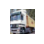

In [19]:
# plt.imshow(images[1])
plot_native_size(images[1])

In [20]:
labels[1]

9

convert to one-hot targets for multi-classification

In [21]:
target_tensor = torch.nn.functional.one_hot(torch.tensor(labels)).to(dtype=torch.float32).to(device)
test_target_tensor = torch.tensor(test_labels)
target_tensor

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], device='cuda:0')

pytorch expects channel before spatial dimensions

In [22]:
images = np.transpose(images, (0, 3, 1, 2))
test_images = np.transpose(test_images, (0, 3, 1, 2))

In [23]:
input_tensor = torch.tensor(images).to(dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_images).to(dtype=torch.float32)

In [24]:
input_ds = torch.utils.data.TensorDataset(input_tensor, target_tensor)
test_ds = torch.utils.data.TensorDataset(test_tensor, test_target_tensor)

In [25]:
train_ds, val_ds = torch.utils.data.random_split(input_ds, [0.9, 0.1])

In [26]:
mini_batch_size = 64

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=mini_batch_size, shuffle=True, drop_last=False)
valid_dl = torch.utils.data.DataLoader(val_ds, batch_size=mini_batch_size * 2)

In [27]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.2),

            nn.Flatten(),
            nn.Linear(2048, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10)
        )

    def forward(self, X):
        X = self.cnn(X)
        return X

In [28]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters())

number of trainable model parameters

In [29]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

551466

In [30]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [31]:
early_stopping = EarlyStopping(patience=5, delta=0.01)

In [32]:
def fit(epochs, model, optimizer, train_dl, valid_dl=None):
    loss_func = nn.CrossEntropyLoss()

    # loop over epochs
    for epoch in range(epochs):
        model.train()

        # loop over mini-batches
        for X_mb, y_mb in train_dl:
            y_hat = model(X_mb)

            loss = loss_func(y_hat, y_mb)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            train_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in train_dl)
            valid_loss = sum(loss_func(model(X_mb), y_mb) for X_mb, y_mb in valid_dl)
        print('epoch {}, training loss {}'.format(epoch + 1, train_loss / len(train_dl)))
        print('epoch {}, validation loss {}'.format(epoch + 1, valid_loss / len(valid_dl)))

        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    print('Finished training')

    return model

In [33]:
epochs = 50

model = fit(epochs, model, optimizer, train_dl, valid_dl)

epoch 1, training loss 1.1092671155929565
epoch 1, validation loss 1.1552807092666626
epoch 2, training loss 0.8095214366912842
epoch 2, validation loss 0.8658336997032166
epoch 3, training loss 0.6936416029930115
epoch 3, validation loss 0.7760641574859619
epoch 4, training loss 0.8314303159713745
epoch 4, validation loss 0.9069797396659851
epoch 5, training loss 0.5607614517211914
epoch 5, validation loss 0.6671698689460754
epoch 6, training loss 0.4350407123565674
epoch 6, validation loss 0.5618207454681396
epoch 7, training loss 0.4751538634300232
epoch 7, validation loss 0.6206489205360413
epoch 8, training loss 0.3765409290790558
epoch 8, validation loss 0.5530676245689392
epoch 9, training loss 0.3900775611400604
epoch 9, validation loss 0.5584467649459839
epoch 10, training loss 0.3182655870914459
epoch 10, validation loss 0.5263356566429138
epoch 11, training loss 0.2773411273956299
epoch 11, validation loss 0.49637317657470703
epoch 12, training loss 0.268319696187973
epoch 1

In [34]:
early_stopping.load_best_model(model)
model = model.cpu()

In [35]:
def evaluation(ds, model, train=False):
    with torch.no_grad():
        preds = model(ds[:][0].cpu())

    # take output node with highest probability
    yhat = np.argmax(preds, axis=1)
    y = ds[:][1].cpu()

    # from one-hot back to labels
    if train:
        y = torch.argmax(y, dim=1)

    metric = MulticlassAccuracy()

    metric.update(yhat, y)
    return metric.compute()

In [36]:
evaluation(train_ds, model, train=True)

tensor(0.9731)

In [37]:
evaluation(val_ds, model, train=True)

tensor(0.8514)

In [38]:
evaluation(test_ds, model)

tensor(0.8535)

accuracy with batch1 training data only: 70%